In [13]:
# zeppalin interop with mapplot
import StringIO
def show(p):
    img = StringIO.StringIO()
    p.savefig(img, format='svg')
    img.seek(0)
    print "%html <div style='width:600px'>" + img.buf + "</div>"
    #print "<div style='width:600px'>" + img.buf + "</div>"

%html <div style='width:600px'><?xml version="1.0" encoding="utf-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Created with matplotlib (http://matplotlib.org/) -->
<svg height="432pt" version="1.1" viewBox="0 0 576 432" width="576pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{stroke-linecap:butt;stroke-linejoin:round;}
  </style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="
M0 432
L576 432
L576 0
L0 0
z
" style="fill:#ffffff;"/>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="
M72 388.8
L518.4 388.8
L518.4 43.2
L72 43.2
z
" style="fill:#ffffff;"/>
   </g>
   <g id="patch_3">
    <path clip-path="url(#p7ff5b81e1d)" d="
M109.2 388.8
L142.68 388.8
L142.68 43.2
L109.2 43.2
z
" style="fill:#0000ff;stroke:#000000;"/>
   </g>
   <g id="patch_4">
    <path clip-path="url(#p7ff5b81e1d)" d="
M142.68 388.8
L176.16 388.8
L

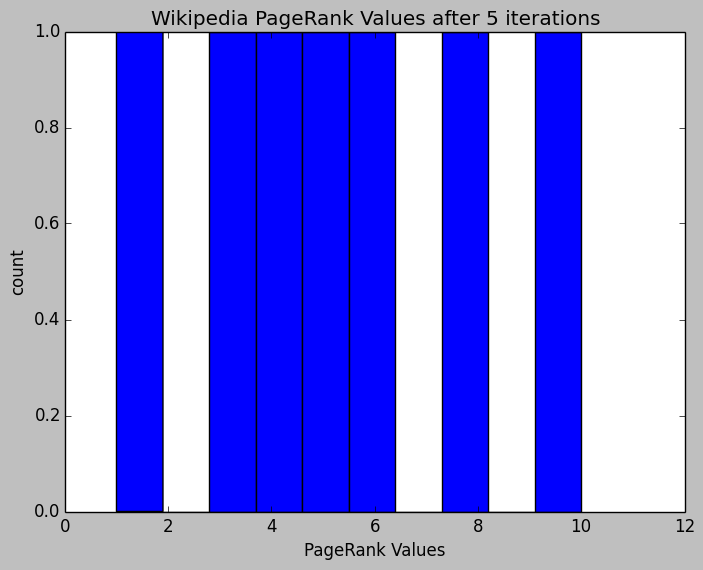

In [14]:
plt.hist([1, 3, 4, 5, 6, 8, 10])
plt.title("Wikipedia PageRank Values after 5 iterations")
plt.xlabel("PageRank Values")
plt.ylabel("count")
show(plt)

In [2]:
import os
import sys
spark_home = os.environ['SPARK_HOME'] = 'C:\\spark-1.5.1-bin-hadoop2.4'
#spark_home = os.environ['SPARK_HOME'] = 'C:\\spark-1.6.1-bin-hadoop2.6'

if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python', 'lib', 'py4j-0.8.2.1-src.zip'))
#sys.path.insert(0,os.path.join(spark_home,'python', 'lib', 'py4j-0.9-src.zip'))
execfile(os.path.join(spark_home,'python', 'pyspark', 'shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.1
      /_/

Using Python version 2.7.5 (default, Jul  1 2013 12:41:55)
SparkContext available as sc, HiveContext available as sqlContext.


# HW11.0  Broadcast versus Caching in Spark

... to add explaination on the difference between broadcasting and caching

In [16]:
# generate data
import numpy as np
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

Iteration0
[[ 0.65063694  0.68236631]
 [ 3.90278939  2.61822066]
 [ 2.26027557  5.78619402]]


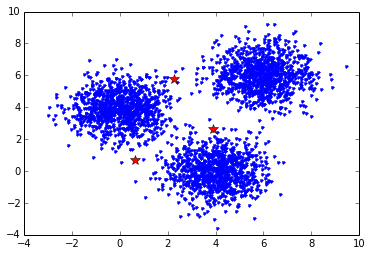

Iteration1
[[ 0.95890057  1.58112756]
 [ 5.05386286  1.93436863]
 [ 2.95825398  5.59431669]]


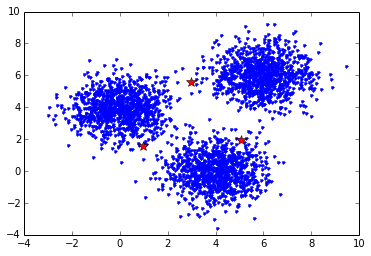

Iteration2
[[ 0.43387771  2.71298057]
 [ 4.76570132  0.80463859]
 [ 4.48135283  5.9685632 ]]


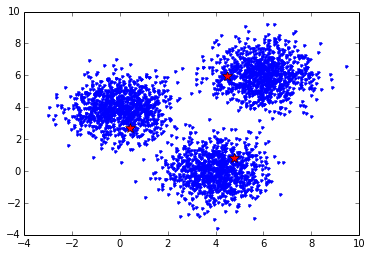

Iteration3
[[ 0.01688563  3.84742191]
 [ 4.06907157 -0.00896619]
 [ 5.89510728  6.04147129]]


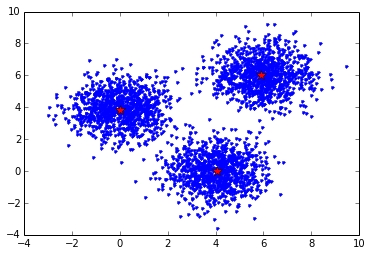

Iteration4
[[  2.60797518e-04   3.94806714e+00]
 [  4.00612354e+00  -3.09988645e-03]
 [  5.95821713e+00   6.03632785e+00]]


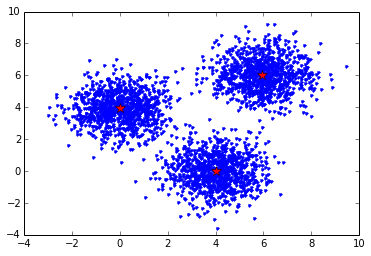

Iteration5
[[ -6.11227108e-04   3.95329581e+00]
 [  4.00197521e+00   5.43177150e-04]
 [  5.96119026e+00   6.03744988e+00]]


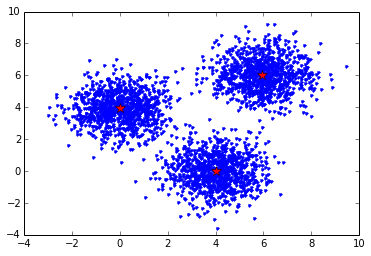

Final Results:
[[ -6.11227108e-04   3.95329581e+00]
 [  4.00197521e+00   5.43177150e-04]
 [  5.96119026e+00   6.03744988e+00]]


In [18]:
%matplotlib inline
import pylab 

# Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids_broadcasted.value)**2, axis=1).argmin() # use broadcasted centroid
    return (closest_centroid_idx,(x,1))

def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("data.csv").cache()
iter_num = 0
for i in range(10):
    centroids_broadcasted = sc.broadcast(centroids) # broadcast centroids before any distributed computing
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    if np.sum(np.absolute(centroids_new-centroids))<0.01:
        break
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    centroids = centroids_new
    print centroids
    #plot_iteration(centroids)
print "Final Results:"
print centroids

# HW11.1  Loss Functions

... to do

# HW11.2 Gradient descent

In the context of logistic regression describe and define three flavors of penalized loss functions.  
Are these all supported in Spark MLLib (include online references to support your answers)?

Descibe probabilitic interpretations of the L1 and L2 priors for penalized logistic regression
(HINT: see synchronous slides for week 11 for details)

In the context of logistic regression, the three flavors of penalized terms are:
- L1 Reg, which penalizes for sum of absolute weights:
![alt text](http://people.ischool.berkeley.edu/~kuanlin/l1_reg.PNG "L1 Reg")
- L2 Reg, penalizes sum of squared weights:
![alt text](http://people.ischool.berkeley.edu/~kuanlin/l2_reg.PNG "L2 Reg")
- Elastic Net, penalizes a linear combination of L1 and L2 norms:
![alt text](http://people.ischool.berkeley.edu/~kuanlin/elastic_net.PNG "Elastic Net Reg")

All of the above three regularization methods are supported by spark.mllib:<br/>
http://spark.apache.org/docs/latest/mllib-linear-methods.html#regularizers

#### Probablisitic interpretation of L1 and L2 priors:

L1 regularization can be interpreted as using Laplace distribution as the prior distribution for the model weights, where as L2 regularization can be interpreted as using gaussian distribution as the prior distribution for the model weights.
![alt text](http://people.ischool.berkeley.edu/~kuanlin/gaussian_vs_laplace.PNG "Distribution Overlay")

The Laplace distribution has more density closer to mean (usually zero in most settings) in comparison to the gaussian distribution, and therefore L1 regularization will tend to push the model weights toward zero.

# HW11.3  Logistic Regression

Generate 2 sets of linearly separable data with 100 data points each using the data generation code
 provided below and plot each in separate plots. Call one the training set and the other the testing set.

In [61]:
import numpy as np
np.random.seed(0)
def generateData(n):
    """ 
    generates a 2D linearly separable dataset with n samples. 
    The third element of the sample is the label
    """
    xb = (np.random.normal(1,0.2,n)*2-1)/2-0.5
    yb = (np.random.normal(-1,0.2,n)*2-1)/2+0.5
    xr = (np.random.normal(1,0.2,n)*2-1)/2+0.5
    yr = (np.random.normal(-1,0.2,n)*2-1)/2-0.5
    inputs = []
    for i in range(len(xb)):
        inputs.append([xb[i],yb[i],1])
        inputs.append([xr[i],yr[i],-1])
    return inputs

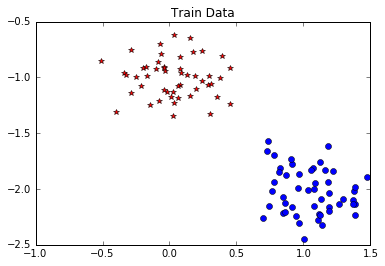

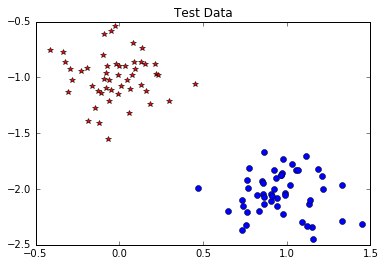

In [62]:
%matplotlib inline
import pylab

# generate 100 linearly seperatable data and plot them
data_lin_seperable_train = generateData(50) # train data
data_lin_seperable_test = generateData(50) # test data

pylab.plot([d[0] for d in data_lin_seperable_train if d[2]==1], [d[1] for d in data_lin_seperable_train if d[2]==1],'*', color = 'red')
pylab.plot([d[0] for d in data_lin_seperable_train if d[2]==-1], [d[1] for d in data_lin_seperable_train if d[2]==-1],'o', color = 'blue')
pylab.plt.title("Train Data")
pylab.show()
#show(pylab.plt)

pylab.plot([d[0] for d in data_lin_seperable_test if d[2]==1], [d[1] for d in data_lin_seperable_test if d[2]==1],'*', color = 'red')
pylab.plot([d[0] for d in data_lin_seperable_test if d[2]==-1], [d[1] for d in data_lin_seperable_test if d[2]==-1],'o', color = 'blue')
pylab.plt.title("Test Data")
pylab.show()
#show(pylab.plt)

Modify this data generation code to generating non-linearly separable training and testing datasets 
(with approximately 10% of the data falling on the wrong side of the separating hyperplane. Plot the resulting datasets. 

In [3]:
import numpy as np
np.random.seed(0)
def generateData2(n):
    """ 
    non-linearly seperable data
    """
    xb = np.random.normal(0,0.5,n)-0.5
    yb = np.random.normal(0,0.5,n)+0.5
    xr = np.random.normal(0,0.5,n)+0.5
    yr = np.random.normal(0,0.5,n)-0.5
    inputs = []
    for i in range(len(xb)):
        inputs.append([xb[i],yb[i],1])
        inputs.append([xr[i],yr[i],-1])
    return inputs

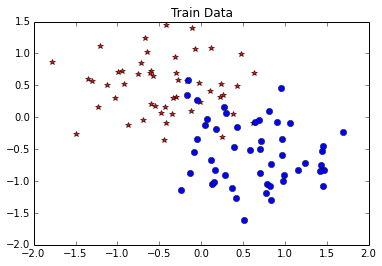

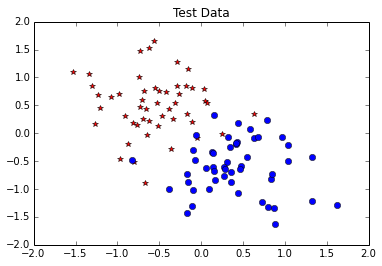

In [4]:
%matplotlib inline
import pylab

# generate 100 linearly seperatable data and plot them
data_lin_inseperable_train = generateData2(50) # train data
data_lin_inseperable_test = generateData2(50) # test data

pylab.plot([d[0] for d in data_lin_inseperable_train if d[2]==1], [d[1] for d in data_lin_inseperable_train if d[2]==1],'*', color = 'red')
pylab.plot([d[0] for d in data_lin_inseperable_train if d[2]==-1], [d[1] for d in data_lin_inseperable_train if d[2]==-1],'o', color = 'blue')
pylab.plt.title("Train Data")
pylab.show()
#show(pylab.plt)

pylab.plot([d[0] for d in data_lin_inseperable_test if d[2]==1], [d[1] for d in data_lin_inseperable_test if d[2]==1],'*', color = 'red')
pylab.plot([d[0] for d in data_lin_inseperable_test if d[2]==-1], [d[1] for d in data_lin_inseperable_test if d[2]==-1],'o', color = 'blue')
pylab.plt.title("Test Data")
pylab.show()
#show(pylab.plt)

NOTE: For the remainder of this problem please use the non-linearly separable training and testing datasets.

Using MLLib  train up a LASSO logistic regression model with the training dataset and evaluate with the testing set. 
What a good number of iterations for training the logistic regression model? Justify with plots and words. 

In [65]:
from pyspark.mllib.classification import LogisticRegressionWithSGD
#from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.regression import LabeledPoint

# convert data to an RDD of labeled points
def parsePoint(data):
    if data[2] == -1:
        label = 0
    else:
        label = 1
    return LabeledPoint(label, [data[0], data[1]])

train_data = sc.parallelize(data_lin_inseperable_train).map(parsePoint).cache()
test_data = sc.parallelize(data_lin_inseperable_test).map(parsePoint).cache()

test_metric_results = []
for iter_n in range(1,11):
    model = LogisticRegressionWithSGD.train(data=train_data, regType="l1", intercept=True,
                            miniBatchFraction=1.0, iterations=iter_n) # lasso regression
    accuracy = test_data.map(lambda lp: ((float(model.predict(lp.features))==lp.label), 1)).reduce(lambda a,b: (a[0]+b[0], a[1]+b[1]))
    accuracy = 1.0*accuracy[0]/accuracy[1]
    test_metric_results.append((iter_n,accuracy))
    print "Iter %s | Accuracy:%.4f" %(iter_n, accuracy)


Iter 1 | Accuracy:0.5100
Iter 2 | Accuracy:0.6000
Iter 3 | Accuracy:0.6900
Iter 4 | Accuracy:0.7700
Iter 5 | Accuracy:0.8200
Iter 6 | Accuracy:0.8900
Iter 7 | Accuracy:0.9100
Iter 8 | Accuracy:0.9300
Iter 9 | Accuracy:0.9300
Iter 10 | Accuracy:0.9500


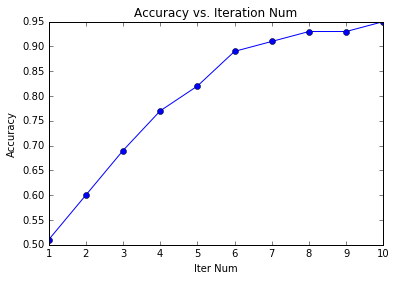

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([d[0] for d in test_metric_results], [d[1] for d in test_metric_results], '-o')
plt.title("Accuracy vs. Iteration Num")
plt.xlabel("Iter Num")
plt.ylabel("Accuracy")
plt.show()

Based on accuracy, the SGD implementation of LogisticRegression with L1 regularization seems to begin to level-out when iteration is about 8 or more.

Derive and implement in Spark a weighted  LASSO logistic regression. Implement a convergence test of your choice to 
check for termination within your training algorithm . 

Weight the above training dataset as follows:  Weight each example using the inverse vector length (Euclidean norm): 

weight(X)= 1/||X||, 

where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

Here X is vector made up of X1 and X2.

Evaluate your homegrown weighted  LASSO logistic regression on the test dataset. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge.

Does Spark MLLib have a weighted LASSO logistic regression implementation. If so use it and report your findings on the weighted training set and test set.

In [58]:
from collections import namedtuple
import numpy as np
Point = namedtuple('Point', 'x y')

def readPoint(data):
    label = data[2]
    x = [data[0], data[1], 1.0]  #add bias term
    return Point(x, label)

def vectorWeight(v1, v2):
    weight = 1.0/((v1**2+v2**2)**0.5)
    if weight < 0.1:
        weight = 0.1
    elif weight > 10:
        weight = 10
    return weight

def WeightedlogisticRegressionGD(data, wInitial=None, learningRate=0.05, iterations=10, regParam=0.01, regType=None, stopCriteria=0.0001):
    featureLen = len(data.take(1)[0].x)
    #total_weight = data.count()
    total_weight = data.map(lambda p: vectorWeight(p.x[0], p.x[1])).reduce(lambda a,b: a+b)
    if wInitial is None:
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:
        w = wInitial
    for i in range(iterations):
        #print "Iteration %s"%(i+1)
        wBroadcast = sc.broadcast(w)
        gradient = data.map(lambda p: vectorWeight(p.x[0], p.x[1])*(1 / (1 + np.exp(-p.y*np.dot(wBroadcast.value, p.x)))-1) * p.y * np.array(p.x))\
                    .reduce(lambda a, b: a + b)
        #gradient = data.map(lambda p: (1 / (1 + np.exp(-p.y*np.dot(wBroadcast.value, p.x)))-1) * p.y * np.array(p.x))\
        #            .reduce(lambda a, b: a + b)
        if regType == "Ridge":
            wReg = w * 1
            wReg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
        elif regType == "Lasso":
            wReg = w * 1
            wReg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
            wReg = (wReg>0).astype(int) * 2-1
        else:
            wReg = np.zeros(w.shape[0])
        gradient = gradient + regParam * wReg  #gradient:  GD of Sqaured Error+ GD of regularized term 
        wdelta = learningRate * gradient / total_weight # scale by total weight
        
        if sum(abs(wdelta))<=stopCriteria*sum(abs(w)): #Convergence condition
            print "convergenced reached at iteration %"%(i+1)
            break
        #w = w - learningRate * gradient / n
        w = w - wdelta
        #print w
    print "total iterations: %s"%(i+1)
    return w

In [59]:
#temp_data = []
#for line in open('data.csv', 'r'):
#    line = line.strip()
#    temp_data.append([float(d) for d in line.split(',')])
train_data = sc.parallelize(data_lin_inseperable_train).map(readPoint).cache()
test_data = sc.parallelize(data_lin_inseperable_test).map(readPoint).cache()
#train_data = sc.parallelize(temp_data).map(readPoint).cache()
#test_data = sc.parallelize(temp_data).map(readPoint).cache()
w = WeightedlogisticRegressionGD(train_data, regType="Lasso", stopCriteria=0.001, iterations=50, regParam=0.01, learningRate=0.1)
print "final weight:%s"%str(w)

Iteration 1
[-0.6148356  -1.0955336   0.74981987]
Iteration 2
[-0.63082757 -1.07530015  0.7333183 ]
Iteration 3
[-0.64662954 -1.05519875  0.71715554]
Iteration 4
[-0.66224139 -1.03523137  0.70132845]
Iteration 5
[-0.67766319 -1.01539984  0.68583371]
Iteration 6
[-0.69289518 -0.99570583  0.67066782]
Iteration 7
[-0.70793777 -0.97615086  0.65582711]
Iteration 8
[-0.72279155 -0.95673632  0.64130777]
Iteration 9
[-0.73745726 -0.93746344  0.62710582]
Iteration 10
[-0.7519358  -0.91833329  0.61321714]
Iteration 11
[-0.76622822 -0.89934682  0.59963748]
Iteration 12
[-0.78033572 -0.88050482  0.58636249]
Iteration 13
[-0.7942596  -0.86180794  0.57338768]
Iteration 14
[-0.80800132 -0.84325672  0.56070849]
Iteration 15
[-0.82156245 -0.82485154  0.54832025]
Iteration 16
[-0.83494464 -0.80659266  0.53621822]
Iteration 17
[-0.84814967 -0.78848023  0.5243976 ]
Iteration 18
[-0.86117941 -0.77051427  0.51285352]
Iteration 19
[-0.87403579 -0.75269469  0.50158107]
Iteration 20
[-0.88672085 -0.73502129  0

In [60]:
# evaluate on test set
import numpy as np

def isAccurate(x, w, label):
    score = 1.0/(1.0 + np.exp(-1.0*np.dot(w,x)))
    print "label|score: %s | %.4f"%(label, score)
    if (label == 1 and score >= 0.5) or (label == -1 and score < 0.5):
        return 1
    else:
        return 0

def LogisticRegAccuracy(data, w):
    wBroadcast = sc.broadcast(w)
    result = test_data.map(lambda p: (isAccurate(p.x, wBroadcast.value, p.y), 1)).reduce(lambda a,b: (a[0]+b[0], a[1]+b[1]))
    return result[0]*1.0/result[1]

accuracy = LogisticRegAccuracy(test_data, w)
print "Misclassification Error Rate: %s"%(str(100-round(accuracy*100, 4))+"%")

Misclassification Error Rate: 27.0%


# HW11.4 SVMs

Use the non-linearly separable training and testing datasets from HW11.3 in this problem.

Using MLLib  train up a soft SVM model with the training dataset and evaluate with the testing set. What is a good number of iterations for training the SVM model? Justify with plots and words. 

Derive and Implement in Spark a weighted soft linear svm classification learning algorithm.
Evaluate your homegrown weighted soft linear svm classification learning algorithm on the weighted training dataset and test dataset from HW11.3. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge?  How many support vectors do you end up?

Does Spark MLLib have a weighted soft SVM learner. If so use it and report your findings on the weighted training set and test set. 


#### MLlib SVMWithSGD

In [5]:
from pyspark.mllib.classification import SVMWithSGD
#from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.regression import LabeledPoint

# convert data to an RDD of labeled points
def parsePoint(data):
    if data[2] == -1:
        label = 0
    else:
        label = 1
    return LabeledPoint(label, [data[0], data[1]])

train_data = sc.parallelize(data_lin_inseperable_train).map(parsePoint).cache()
test_data = sc.parallelize(data_lin_inseperable_test).map(parsePoint).cache()

test_metric_results = []
for iter_n in range(1,11):
    model = SVMWithSGD.train(data=train_data, regType="l1", intercept=True,
                            miniBatchFraction=1.0, iterations=iter_n) # lasso, same parameters as logistic reg for comparison
    accuracy = test_data.map(lambda lp: ((float(model.predict(lp.features))==lp.label), 1)).reduce(lambda a,b: (a[0]+b[0], a[1]+b[1]))
    accuracy = 1.0*accuracy[0]/accuracy[1]
    test_metric_results.append((iter_n,accuracy))
    print "Iter %s | Accuracy:%.4f" %(iter_n, accuracy)


Iter 1 | Accuracy:0.5700
Iter 2 | Accuracy:0.8000
Iter 3 | Accuracy:0.9400
Iter 4 | Accuracy:0.9500
Iter 5 | Accuracy:0.9300
Iter 6 | Accuracy:0.9400
Iter 7 | Accuracy:0.9400
Iter 8 | Accuracy:0.9400
Iter 9 | Accuracy:0.9400
Iter 10 | Accuracy:0.9400


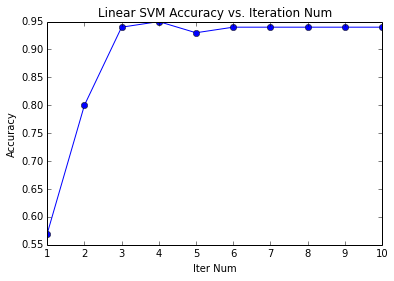

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([d[0] for d in test_metric_results], [d[1] for d in test_metric_results], '-o')
plt.title("Linear SVM Accuracy vs. Iteration Num")
plt.xlabel("Iter Num")
plt.ylabel("Accuracy")
plt.show()

For this particular dataset LinearSVM seems to converge very fast, plateauing at 94% accuracy after 3 iterations.  This is much faster than logistic regression. 

#### Home-grown SVM code

In [11]:
from collections import namedtuple
import numpy as np
Point = namedtuple('Point', 'x y')

def readPoint(data):
    label = data[2]
    x = [data[0], data[1], 1.0]  #add bias term
    return Point(x, label)

def vectorWeight(v1, v2):
    weight = 1.0/((v1**2+v2**2)**0.5)
    if weight < 0.1:
        weight = 0.1
    elif weight > 10:
        weight = 10
    return weight

def WeightedSVMRegressionGD(data, wInitial=None, learningRate=0.05, iterations=100, regParam=0.01, regType=None, stopCriteria=0.0001):
    featureLen = len(data.take(1)[0].x)
    total_weight = data.map(lambda p: vectorWeight(p.x[0], p.x[1])).reduce(lambda a,b: a+b)
    if wInitial is None:
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:
        w = wInitial
        
    for i in range(iterations):
        wBroadcast = sc.broadcast(w)
        
        sv = data.filter(lambda p: p.y*np.dot(wBroadcast.value, p.x) < 1).cache() # find the support vectors
        
        if sv.isEmpty(): # no more support vectors
            break
        
        # calculate weighted gradients (hinge loss)
        gradient = -1.0*sv.map(lambda p: vectorWeight(p.x[0], p.x[1])*p.y*np.array(p.x)).reduce(lambda a,b: a+b)/total_weight
        
        if regType == "Ridge":
            wReg = w * 1
            wReg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
        elif regType == "Lasso":
            wReg = w * 1
            wReg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
            wReg = (wReg>0).astype(int) * 2-1
        else:
            wReg = np.zeros(w.shape[0])
            
        gradient = gradient + regParam * wReg  #gradient:  GD of Sqaured Error+ GD of regularized term 
        wdelta = learningRate * gradient
        
        if sum(abs(wdelta))<=stopCriteria*sum(abs(w)): #Convergence condition
            print "convergenced reached at iteration %"%(i+1)
            break
        w = w - wdelta
        
        #print "iteration %s"%i
        #print w
    
    return (w, i+1, sv.count()) # learned weights, total iters, support vector counts

In [12]:
train_data = sc.parallelize(data_lin_inseperable_train).map(readPoint).cache()
test_data = sc.parallelize(data_lin_inseperable_test).map(readPoint).cache()
w = WeightedSVMRegressionGD(train_data, regType="Lasso", stopCriteria=0.001, iterations=50, regParam=0.01, learningRate=0.1)
print "final weight:%s | total iters:%s | SV counts: %s"%(str(w[0]), str(w[1]), str(w[2]))

iteration 0
[ 0.32339399 -1.73490252  0.35357078]
iteration 1
[ 0.29089001 -1.70177022  0.35325806]
iteration 2
[ 0.25838602 -1.66863791  0.35294534]
iteration 3
[ 0.22588204 -1.63550561  0.35263263]
iteration 4
[ 0.19337805 -1.6023733   0.35231991]
iteration 5
[ 0.16087407 -1.569241    0.35200719]
iteration 6
[ 0.12837008 -1.53610869  0.35169447]
iteration 7
[ 0.0958661  -1.50297639  0.35138175]
iteration 8
[ 0.06336212 -1.46984408  0.35106903]
iteration 9
[ 0.03085813 -1.43671178  0.35075631]
iteration 10
[-0.00164585 -1.40357947  0.3504436 ]
iteration 11
[-0.03214984 -1.37044717  0.35013088]
iteration 12
[-0.06265382 -1.33731486  0.34981816]
iteration 13
[-0.09315781 -1.30418256  0.34950544]
iteration 14
[-0.12366179 -1.27105025  0.34919272]
iteration 15
[-0.15416577 -1.23791794  0.34888   ]
iteration 16
[-0.18466976 -1.20478564  0.34856728]
iteration 17
[-0.21517374 -1.17165333  0.34825457]
iteration 18
[-0.24567773 -1.13852103  0.34794185]
iteration 19
[-0.27555187 -1.10527542  0.

In [13]:
# evaluate on test set
import numpy as np

def isAccurateSVM(x, w, label):
    score = label*np.dot(w, x)
    print "label|score: %s | %.4f"%(label, score)
    if score >= 0:
        return 1
    else:
        return 0

def SVMRegAccuracy(data, w):
    wBroadcast = sc.broadcast(w)
    result = data.map(lambda p: (isAccurateSVM(p.x, wBroadcast.value, p.y), 1)).reduce(lambda a,b: (a[0]+b[0], a[1]+b[1]))
    return result[0]*1.0/result[1]

accuracy = SVMRegAccuracy(test_data, w[0])
print "Misclassification Error Rate: %s"%(str(100-round(accuracy*100, 4))+"%")

Misclassification Error Rate: 24.0%


# 11.5  [OPTIONAL] Distributed Perceptron algorithm.

Using the following papers as background:
http://static.googleusercontent.com/external_content/untrusted_dlcp/research.google.com/en//pubs/archive/36266.pdf

https://www.dropbox.com/s/a5pdcp0r8ptudgj/gesmundo-tomeh-eacl-2012.pdf?dl=0

http://www.slideshare.net/matsubaray/distributed-perceptron 

Implement each of the following flavors of perceptron learning algorithm:

1. Serial (All Data): This is the classifier returned if trained serially on all the 
available data.  On a single computer for example (Mistake driven)
2. Serial (Sub Sampling): Shard the data, select one shard randomly and train serially. 
3. Parallel (Parameter Mix): Learn a perceptron locally on each shard: 
Once learning is complete combine each learnt percepton using a uniform weighting
4. Parallel (Iterative Parameter Mix) as described in the above papers.

#### Perceptron Gradient Descent

In [64]:
import numpy as np

def perceptronSubGradientCalc(data, w, regParam, feature_size):
    #gradient = data.map(lambda p: -p.y*np.array(p.x) if (p.y*np.dot(w.value,p.x))<0 else np.zeros(feature_size)).reduce(lambda a, b: a+b)
    incorrect = data.filter(lambda p: np.dot(w.value,p.x)*p.y < 0)
    if incorrect.isEmpty():
        gradient = np.zeros(feature_size)
    else:
        gradient = incorrect.map(lambda p: -p.y*np.array(p.x)).reduce(lambda a,b: a+b)
    wreg = np.array(w.value)  # L2 reg
    wreg[-1] = 0 # don't count the bias term in reg
    return gradient/data.count() + regParam*wreg

def perceptronAccuracy(data, w):
    correct_count = data.map(lambda p: 1 if np.dot(w.value, p.x)*p.y > 0 else 0).reduce(lambda a,b: a+b)
    return 1.0*correct_count/data.count()

In [7]:
from collections import namedtuple
import numpy as np
Point = namedtuple('Point', 'x y')

def readPoint(data):
    label = data[2]
    x = [data[0], data[1], 1.0]  #add bias term
    return Point(x, label)

train_data = sc.parallelize(data_lin_inseperable_train).map(readPoint).cache()
test_data = sc.parallelize(data_lin_inseperable_test).map(readPoint).cache()

#train_data.count()

#### Train serially on all data

In [65]:
def perceptronGDSerialAll(data, wInitial=None, nShards=1, nIter=10, stopCriteria=0.001, 
                 learningRate=0.05, regParam=0.01):
    feature_size = len(data.take(1)[0].x)
    if wInitial is None:
        w = np.random.normal(size=feature_size)
    else:
        w = wInitial
    #model_data = data.randomSplit([1.0/nShards]*nShards) # split data into shards
    for i in range(nIter):
        wb = sc.broadcast(w) # broadcast weight
        wdelta = learningRate*perceptronSubGradientCalc(data, wb, regParam, feature_size)
        if sum(abs(wdelta))<=stopCriteria*sum(abs(w)):
            break
        w = w - wdelta
    return w

w = perceptronGDSerialAll(train_data)
print "learned weight: %s" % str(w)
print "Accuracy: %s" % perceptronAccuracy(test_data, sc.broadcast(w))

learned weight: [-2.16751633  0.22811287 -0.02710354]
Accuracy: 0.88


### Train serially on random shards

In [80]:
def perceptronGDSerialShards(data, wInitial=None, nShards=1, nIter=10, stopCriteria=0.001, 
                 learningRate=0.05, regParam=0.01):
    feature_size = len(data.take(1)[0].x)
    if wInitial is None:
        w = np.random.normal(size=feature_size)
    else:
        w = wInitial
    for shared_data in data.randomSplit([1.0/nShards]*nShards): # split data into shards
        for i in range(nIter):
            wb = sc.broadcast(w) # broadcast weight
            wdelta = learningRate*perceptronSubGradientCalc(shared_data, wb, regParam, feature_size)
            if sum(abs(wdelta))<=stopCriteria*sum(abs(w)):
                break
            w = w - wdelta
    return w

w = perceptronGDSerialShards(train_data, nShards=4, nIter=10)
print "learned weight: %s" % str(w)
print "Accuracy: %s" % perceptronAccuracy(test_data, sc.broadcast(w))

learned weight: [-0.0394292   0.17467005 -0.00799986]
Accuracy: 0.9


#### Parameter Mixing Method (non-iterative)

In [78]:
def percetronTrainLocal(data, w, regParam, feature_size, learningRate, nIter):
    # train with local data instead of RDD
    weight = np.array(w.value)
    for i in range(nIter):
        gradient = sum(map(lambda p: -p.y*np.array(p.x) if (p.y*np.dot(weight,p.x))<0 else np.zeros(feature_size), data))
        wreg = weight*1  # L2 reg
        wreg[-1] = 0 # don't count the bias term in reg
        weight -= learningRate*(gradient/len(data) + regParam*wreg)
    return weight

def perceptronGDSerialParaMix(data, wInitial=None, nShards=1, nIter=10, learningRate=0.05, regParam=0.01):
    feature_size = len(data.take(1)[0].x)
    if wInitial is None:
        w = np.random.normal(size=feature_size)
    else:
        w = wInitial
    wb = sc.broadcast(w)
    model_data = sc.parallelize([d.collect() for d in data.randomSplit([1.0/nShards]*nShards)]) # split data into shards in RDD
    learned_w = model_data.map(lambda data: percetronTrainLocal(data, wb, regParam, feature_size, learningRate, nIter)).collect()
    return sum(learned_w)/len(learned_w) # take uniform average of the learned weights

w = perceptronGDSerialParaMix(train_data, nShards=4, nIter=50)
print "learned weight: %s" % str(w)
print "Accuracy: %s" % perceptronAccuracy(test_data, sc.broadcast(w))

learned weight: [ 0.82557121  2.61303986 -0.09620172]
Accuracy: 0.79


#### Iterative Param Mixing

In [77]:
def perceptronGDSerialIterParaMix(data, wInitial=None, nShards=1, nIter=10, learningRate=0.05, regParam=0.01):
    feature_size = len(data.take(1)[0].x)
    if wInitial is None:
        w = np.random.normal(size=feature_size)
    else:
        w = wInitial
    model_data = sc.parallelize([d.collect() for d in data.randomSplit([1.0/nShards]*nShards)]) # split data into shards in RDD
    for i in range(nIter):
        wb = sc.broadcast(w)
        # train only 1 epoch and then do param mixing
        learned_w = model_data.map(lambda data: percetronTrainLocal(data, wb, regParam, feature_size, learningRate, 1)).collect()
        w = sum(learned_w)/len(learned_w) # take uniform average of the learned weights
    return w

w = perceptronGDSerialIterParaMix(train_data, nShards=4, nIter=50)
print "learned weight: %s" % str(w)
print "Accuracy: %s" % perceptronAccuracy(test_data, sc.broadcast(w))

learned weight: [-1.16103408  0.03655426  0.44536896]
Accuracy: 0.74
